## R Notebook for repeated-measures ANOVA lecture

Based on [Crosse et al (2015)](https://www.jneurosci.org/content/35/42/14195.short)

This is the Python notebook I used to simulate the data and generate the figures for my lecture on repeated-measures ANOVA. To run the code, click on each block (a "cell") of code and click the "play" button on the left. There is also a button at the top of the page to "run all" of the cells.

*I originally wrote this script in Python, but I converted it into R with the help of Microsoft Copilot.*


In [13]:
# Load necessary libraries
library(tidyverse)
library(afex)
library(emmeans)
library(car)
library(ggplot2)

### Generate the data

In [39]:
# Set seed for reproducibility
set.seed(42)

# Number of subjects and levels (conditions)
n_subjects <- 20
levels <- c('AV', 'A', 'V')
n_levels <- length(levels)

# Mean values and standard deviation for each level
means <- c(600, 650, 800)
std_dev_sbj <- 100 # standard deviation across participants
std_dev_wthn <- 30 # standard deviation within participants

# Simulate data
df <- data.frame(
  Subject = factor(rep(1:n_subjects, each = n_levels)),
  Condition = factor(rep(levels, times = n_subjects)),
  Response_time = unlist(lapply(1:n_subjects, function(subject) {
    sbj_avg <- rnorm(1, 0, std_dev_sbj)
    sapply(1:n_levels, function(level) {
      value <- rnorm(1, means[level], std_dev_wthn) + sbj_avg
      return(value)
    })
  }))
)

### Plot the data

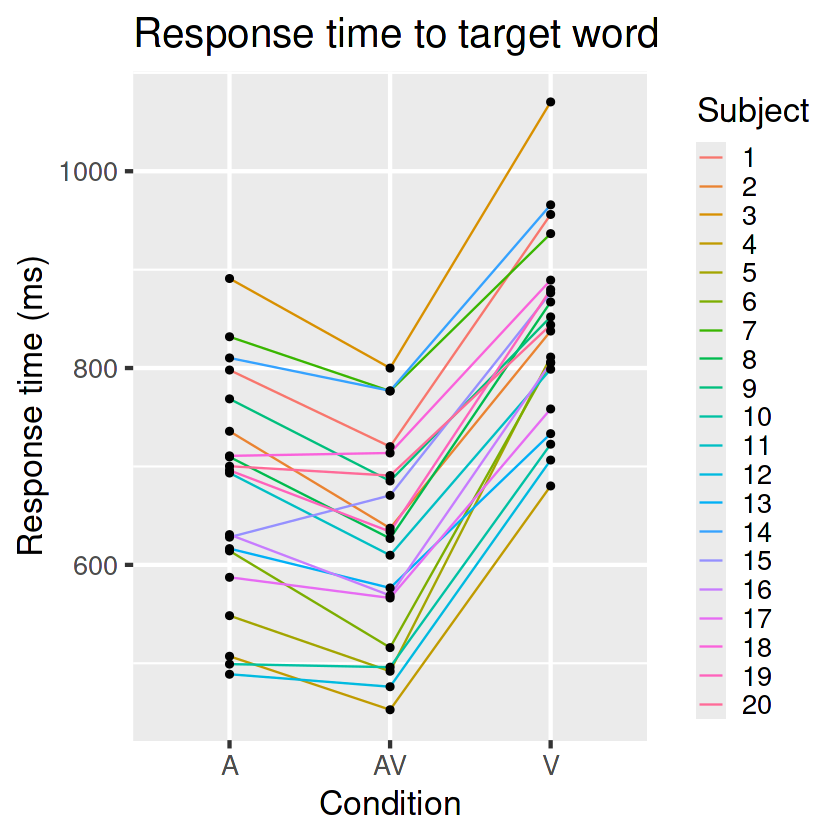

In [40]:
# Plot the data
ggplot(df, aes(x = Condition, y = Response_time, group = Subject)) +
  geom_line(aes(color = Subject)) +
  geom_point() +
  theme_minimal() +
  labs(title = "Response time to target word", x = "Condition", y = "Response time (ms)") +
  theme_grey(base_size=20)

### Run the repeated measures ANOVA

In [41]:
# Run the repeated-measures ANOVA
anova_results <- aov_car(Response_time ~ Error(Subject/Condition), data=df)
summary_aov <- summary(anova_results)
summary_aov

Warning message in summary.Anova.mlm(object$Anova, multivariate = FALSE):
“HF eps > 1 treated as 1”



Univariate Type III Repeated-Measures ANOVA Assuming Sphericity

              Sum Sq num Df Error SS den Df F value    Pr(>F)    
(Intercept) 30458102      1   601374     19  962.30 < 2.2e-16 ***
Condition     510790      2    37537     38  258.54 < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Mauchly Tests for Sphericity

          Test statistic p-value
Condition        0.93454 0.54374


Greenhouse-Geisser and Huynh-Feldt Corrections
 for Departure from Sphericity

           GG eps Pr(>F[GG])    
Condition 0.93856  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

            HF eps  Pr(>F[HF])
Condition 1.037868 7.46439e-23

In [45]:
# Calculate the between-subjects sum-of-squares
SS_total <- sum((data$Response_time - mean(data$Response_time))^2)
sbj_mean <- aggregate(Response_time ~ Subject, data, mean)
SS_sbj <- sum((sbj_mean$Response_time - mean(data$Response_time))^2) * n_levels
SS_within <- SS_total - SS_sbj

cat(sprintf("Total SS = %.2f\n", SS_total))
cat(sprintf("Between-subject SS = %.2f\n", SS_sbj))
cat(sprintf("Within-subject SS = %.2f\n", SS_within))

Total SS = 1149701.66
Between-subject SS = 601374.31
Within-subject SS = 548327.36


### Demonstration of calculating the p-value

NULL


Warning message in df(x, dof1, dof2):
“NaNs produced”


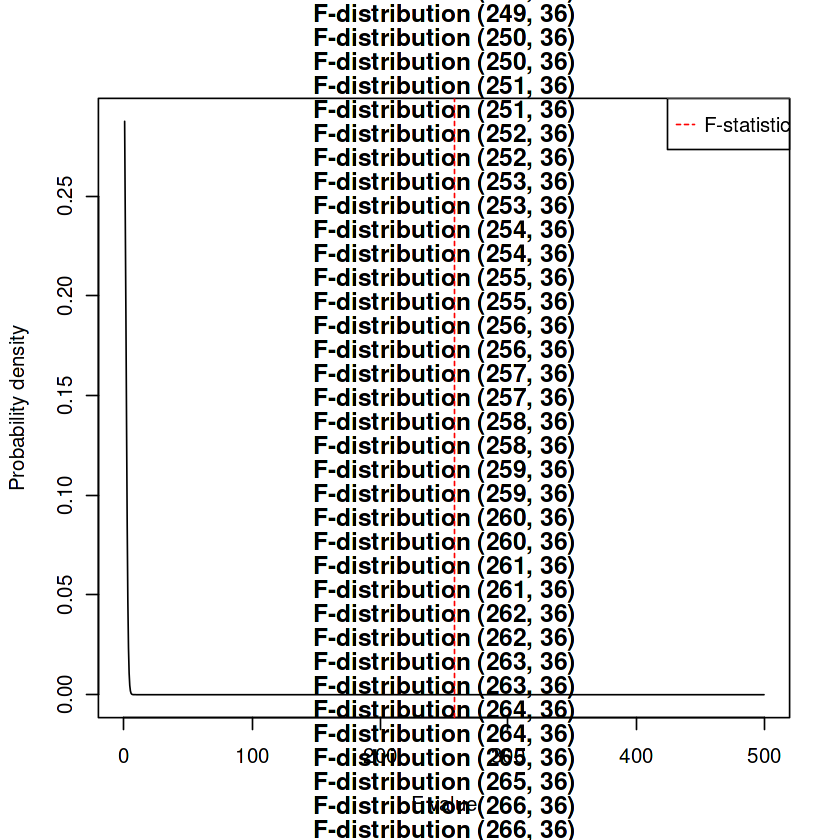

In [54]:
anova_table <- anova(anova_results)
print(anova_table$`Df`[1])

# Get statistic values
dof1 <- summary_aov$

# Plot the F-distribution
x <- seq(0, 500, length.out = 1000)
y <- df(x, dof1, dof2)

plot(x, y, type = "l", main = sprintf("F-distribution (%.0f, %.0f)", dof1, dof2), xlab = "F value", ylab = "Probability density")
abline(v = Fstat, col = "red", lty = 2)
polygon(c(Fstat, x[x >= Fstat]), c(0, y[x >= Fstat]), col = "gray", border = NA)
legend("topright", legend = sprintf("F-statistic = %.1f", Fstat), col = "red", lty = 2)

### Sphericity

In [ ]:
# Demonstration of sphericity
paired_cond <- spread(data, Condition, Response_time)
pairs <- list(c("A", "V"), c("AV", "V"), c("AV", "A"))

par(mfrow = c(1, 3))
for (pair in pairs) {
  plot(paired_cond[[pair[1]]], paired_cond[[pair[2]]], xlab = pair[1], ylab = pair[2], xlim = c(400, 1000), ylim = c(400, 1000))
  abline(lm(paired_cond[[pair[2]]] ~ paired_cond[[pair[1]]]), col = "blue")
}

In [ ]:
# Variability in the difference between conditions
diff_cond <- data.frame(
  `V-A` = paired_cond$V - paired_cond$A,
  `V-AV` = paired_cond$V - paired_cond$AV,
  `A-AV` = paired_cond$A - paired_cond$AV
)

In [ ]:
# Plot the difference between conditions with a box-whisker plot
ggplot(melt(diff_cond), aes(x = variable, y = value)) +
  geom_boxplot() +
  geom_jitter(width = 0.2) +
  labs(x = "Condition", y = "Difference in response time")

In [ ]:
# Mauchly's test for sphericity
sphericity_test <- Anova(lm(Response_time ~ Condition + Error(Subject/Condition), data = data), idata = data.frame(Condition = levels), idesign = ~Condition)
print(sphericity_test)

### Multiple comparisons

In [ ]:
# Multiple comparisons
emmeans_results <- emmeans(anova_results, pairwise ~ Condition)
print(emmeans_results$contrasts)